# Diagnóstico Inicial do Cancelamento - CETEC

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

def plot_percentage(df, x, y, xlabel):   
    counts = df.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index()
    print(counts)
    g = sns.catplot(x=x, y='percent', hue=y, data=counts, kind='bar')
    
    g.set(xlabel = xlabel)
    
    new_title = 'Cancelamento'
    g._legend.set_title(new_title)
    # replace labels
    new_labels = ['Não', 'Sim']
    for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
    plt.show()

df = pd.read_csv('/home/ramon/extrator/survival/evasao-100.csv')

In [2]:
def permutation_test(events, obs_diff, n1):
    n = len(events)
    n2 = n-n1
    idxs = np.arange(0, n)



    values = []
    for i in range(10000):
        foo = np.full(n, False)
        idx_a = np.random.choice(idxs, n1, replace=False)
        foo[idx_a] = True

        diff = np.abs(events[foo].mean() - events[~foo].mean())
        values.append(diff)

    return (np.mean(np.array(values) > obs_diff))

def proportion_test(df, col_name):
    idx = df['time'] == df.groupby('matricula')['time'].transform('max')
    counts = df[idx].groupby(col_name)['event'].mean().values
    obs_diff = np.abs(counts[0] - counts[1])
    n1 = df[idx][col_name].value_counts().values[0]
    events = df.loc[idx, 'event'].values
    
    return (permutation_test(events, obs_diff, n1))

from statsmodels.stats.proportion import proportions_ztest

def proportion_test2(df, col_name):
    idx = df['time'] == df.groupby('matricula')['time'].transform('max')
    count = df[idx].groupby(col_name)['event'].sum().values
    nobs = df[idx].groupby(col_name)['event'].count().values

    stat, pval = proportions_ztest(count, nobs)
    return pval

In [3]:
centro  = 'CETEC'
df = df[df.centro == centro]

In [4]:
df.groupby('time')['event'].value_counts()

time  event
1     0        2712
      1         629
2     0        2364
      1         327
3     0        1929
      1         276
4     0        1596
      1         212
5     0        1312
      1         180
6     0        1070
      1         133
7     0         815
      1          89
8     0         592
      1          57
9     0         429
      1          35
10    0         306
      1          27
11    0         208
      1          23
12    0         121
      1          10
13    0          71
      1           4
14    0          40
      1           4
15    0          21
      1           4
16    0          15
      1           1
17    0          10
      1           2
18    0           3
Name: event, dtype: int64

# Perfil dos Estudantes na Amostra

- 60% cancelaram
- 87% possuem cidade de origem diferente da cidade do campus
- 35% são do sexo feminino
- Idade média dos estudantes é 21
- Há 3341 números de matrículas

In [5]:
idx = (df['time'] == df.groupby('matricula')['time'].transform('max'))

print(df[idx]['event'].value_counts(normalize=True))

print(df[idx]['is_outra_cidade'].value_counts(normalize=True))

print(df[idx]['sexo'].value_counts(normalize=True))

print(df[idx]['idade_ingresso'].mean())

print(df.matricula.nunique())

1    0.602514
0    0.397486
Name: event, dtype: float64
1    0.872194
0    0.127806
Name: is_outra_cidade, dtype: float64
1    0.64771
0    0.35229
Name: sexo, dtype: float64
21.00329242741694
3341


# Q1 Taxa de cancelamento é maior para estudantes cuja cidade de origem difere da cidade do campus?


- Taxa é maior para discentes naturais (67% vs 59%)
- Diferença observada é estatisticamente significativa

1    0.872194
0    0.127806
Name: is_outra_cidade, dtype: float64
   is_outra_cidade  event    percent
0                0      1  66.744731
1                0      0  33.255269
2                1      1  59.299931
3                1      0  40.700069


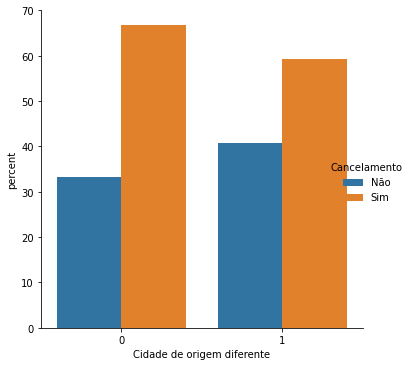

In [6]:
idx = df['time'] == df.groupby('matricula')['time'].transform('max')

print(df[idx]['is_outra_cidade'].value_counts(normalize=True))

plot_percentage(df[idx], 'is_outra_cidade', 'event', 'Cidade de origem diferente')

In [7]:
#print('%.3f'%(proportion_test(df, 'is_outra_cidade')))
print(proportion_test2(df, 'is_outra_cidade'))

0.003326702354899694


# Q2 Taxa de cancelamento é maior para ingressantes no 1o semestre ou 2o semestre letivo? (Ex: taxa de evasão é maior para ingressantes em 2019.1 ou 2019.2?)

- Taxa é maior entre ingressantes no 2o semestre (67% vs 55%)
- A diferença é estatisticamente significativa

1    0.546842
2    0.453158
Name: semestreIngresso, dtype: float64
   semestreIngresso  event    percent
0                 1      1  54.734537
1                 1      0  45.265463
2                 2      1  66.908851
3                 2      0  33.091149


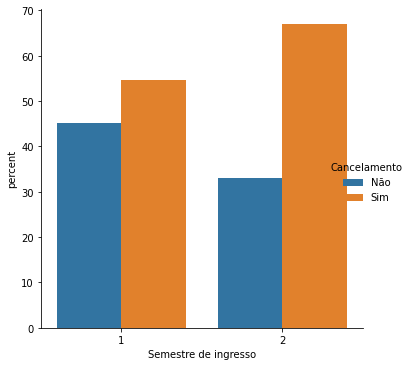

In [8]:
idx = df['time'] == df.groupby('matricula')['time'].transform('max')

print(df[idx]['semestreIngresso'].value_counts(normalize=True))

plot_percentage(df[idx], 'semestreIngresso', 'event', 'Semestre de ingresso')

In [9]:
#print('%.3f'%(proportion_test(df, 'periodoingresso')))
print(proportion_test2(df, 'semestreIngresso'))

8.183991108010816e-13


# Q4 Taxa taxa de cancelamento é maior para homens ou mulheres?

- Taxa é maior para homens (61% vs 59%)
- Diferença observada não é significativa

1    0.64771
0    0.35229
Name: sexo, dtype: float64
   sexo  event    percent
0     0      1  59.303314
1     0      0  40.696686
2     1      1  60.767098
3     1      0  39.232902


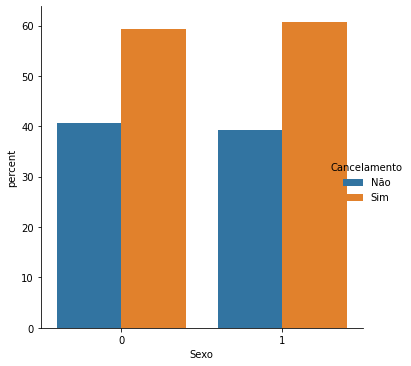

In [10]:
idx = df['time'] == df.groupby('matricula')['time'].transform('max')

print(df[idx]['sexo'].value_counts(normalize=True))

plot_percentage(df[idx], 'sexo', 'event', 'Sexo')

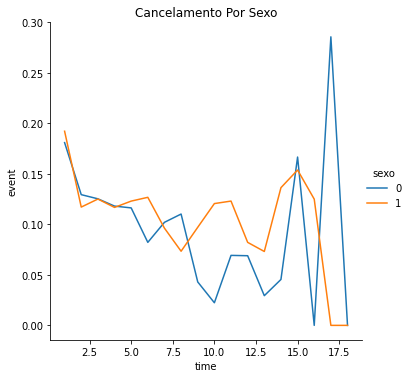

In [11]:
data = df.groupby(['time','sexo']).agg({'event':'mean'}).reset_index()
ax = sns.relplot(x='time', y='event', data=data, hue='sexo',  kind="line")    
ax.set(title='Cancelamento Por Sexo')    

In [12]:
#print('%.3f'%(proportion_test(df, 'sexo')))
print(proportion_test2(df, 'sexo'))

0.4088782570611573


# Q5 Taxa de cancelamento decresce com o tempo?

- A taxa tende a decrescer com o tempo

[Text(0.5, 1.0, 'Cancelamento Geral')]

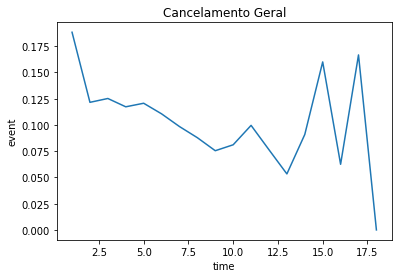

In [13]:
data = df.groupby('time').agg({'event':'mean'}).reset_index()

ax = sns.lineplot(x='time', y='event', data=data)    
ax.set(title='Cancelamento Geral')

# Q6 Taxa de cancelamento difere entre ingressantes por cota e ampla concorrência?

- A taxa é maior para Cotista (64% vs 57%)
- A diferença observada é estatisticamente significativa

0    0.543251
1    0.456749
Name: is_cotista, dtype: float64
   is_cotista  event    percent
0           0      1  57.245179
1           0      0  42.754821
2           1      1  63.826999
3           1      0  36.173001


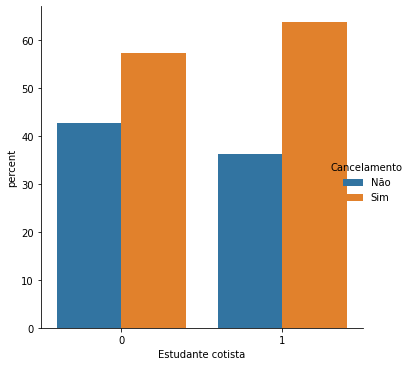

In [14]:
idx = df['time'] == df.groupby('matricula')['time'].transform('max')

print(df[idx]['is_cotista'].value_counts(normalize=True))

plot_percentage(df[idx], 'is_cotista', 'event', 'Estudante cotista')

In [15]:
#print('%.3f'%(proportion_test(df, 'is_cotista')))
print(proportion_test2(df, 'is_cotista'))

0.00010777418469007271


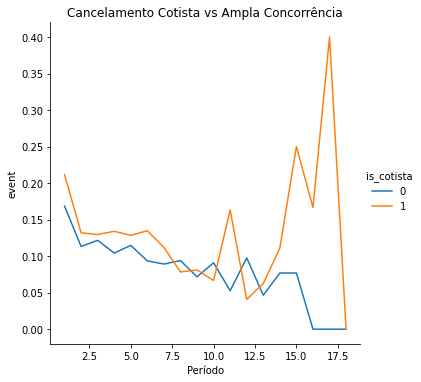

In [16]:
data = df.groupby(['time','is_cotista']).agg({'event':'mean'}).reset_index()
ax = sns.relplot(x='time', y='event', data=data, hue='is_cotista',  kind="line")    
ax.set(title='Cancelamento Cotista vs Ampla Concorrência', xlabel='Período')    

# Q.7 A idade de ingresso afeta a taxa de cancelamento?

- A idade de ingresso parece afetar a taxa

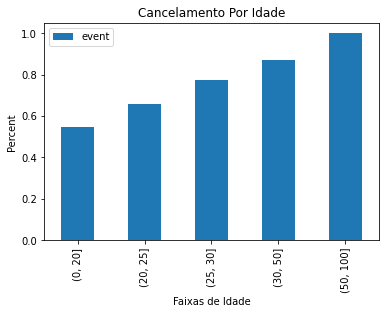

In [17]:
col = 'idade_cat'
df[col] = pd.cut(df.idade_ingresso, bins=[0,20,25,30,50,100])


ax = df[idx].groupby(col).agg({'event':'mean'}).plot.bar()
ax.set(ylabel="Percent")
ax.set(title='Cancelamento Por Idade', xlabel='Faixas de Idade')
plt.show()

# Turno afeta Cancelamento?

In [18]:
idx = (df['time'] == df.groupby('matricula')['time'].transform('max'))

df[idx].groupby('turno').agg({'event':'mean'})

,event
turno,
Matutino e Vespertino,0.602514


# Grau afeta Cancelamento?

In [19]:
idx = (df['time'] == df.groupby('matricula')['time'].transform('max'))

df[idx].groupby('grau').agg({'event':'mean'})

,event
grau,
Bacharelado,0.602514


# Análise Bivariada

Idade Ingresso vs Turno


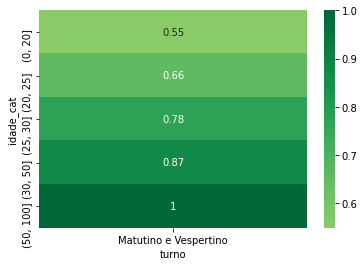

Idade Ingresso vs Grau do Curso


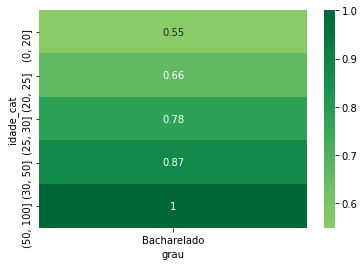

Idade Ingresso vs Sexo


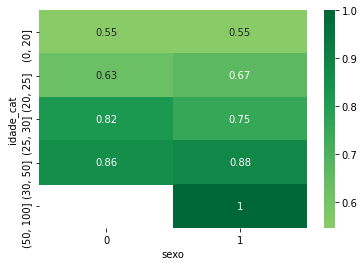

Idade Ingresso vs Cotista


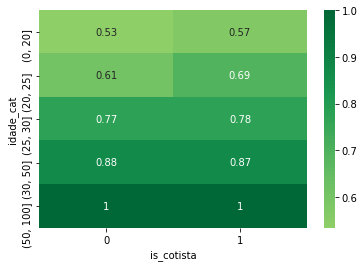

Idade Ingresso vs Migrante


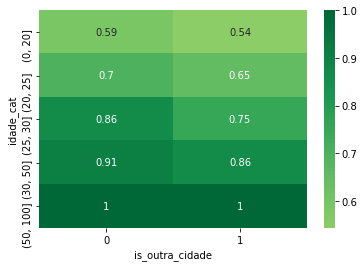

Idade Ingresso vs Período


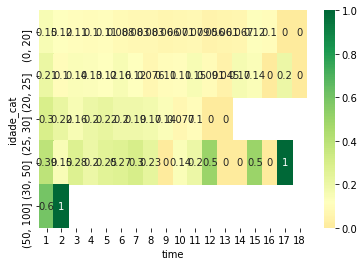

Turno vs Grau do Curso


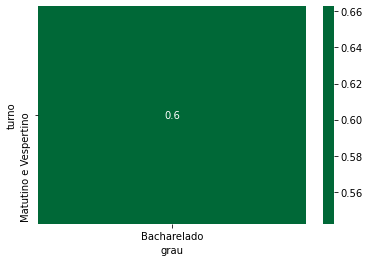

Turno vs Sexo


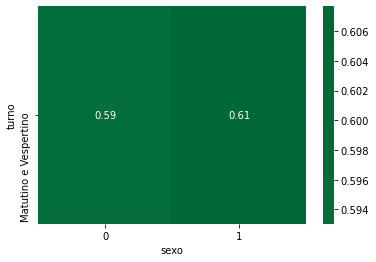

Turno vs Cotista


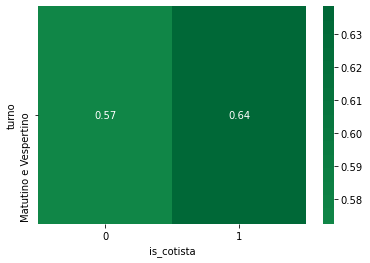

Turno vs Migrante


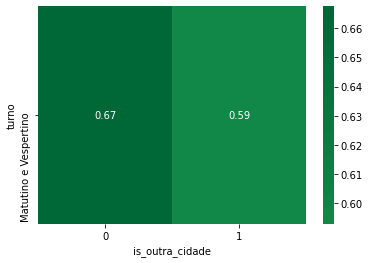

Turno vs Período


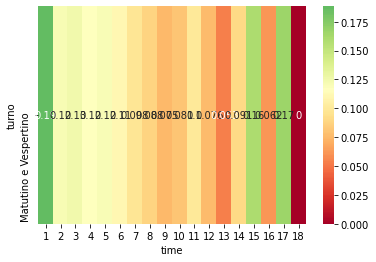

Grau do Curso vs Sexo


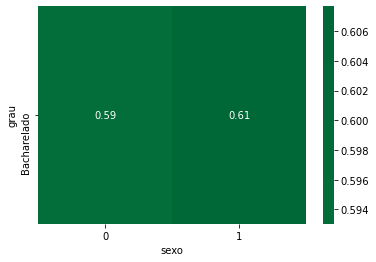

Grau do Curso vs Cotista


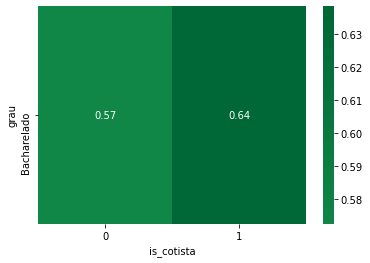

Grau do Curso vs Migrante


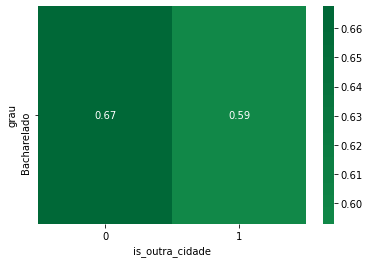

Grau do Curso vs Período


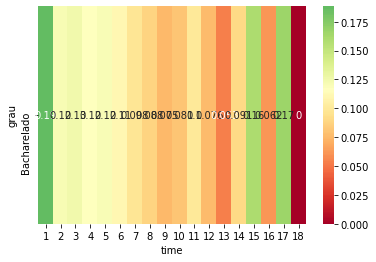

Sexo vs Cotista


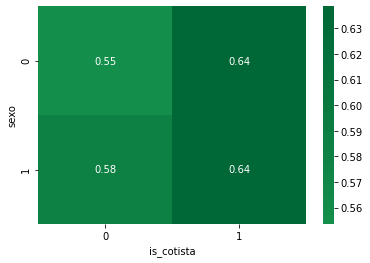

Sexo vs Migrante


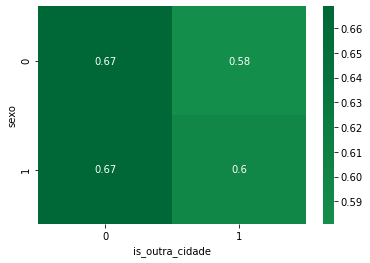

Sexo vs Período


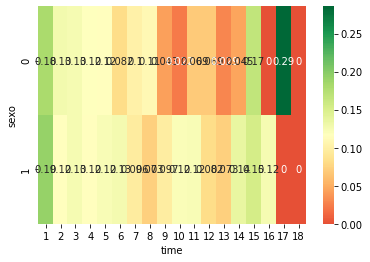

Cotista vs Migrante


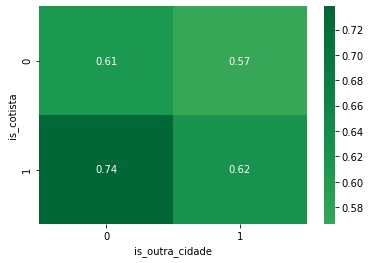

Cotista vs Período


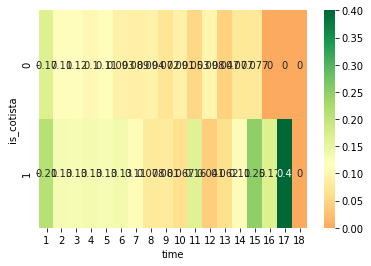

Migrante vs Período


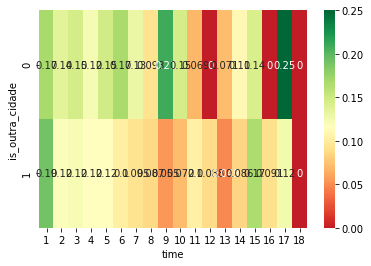

In [20]:
nomes = ['Idade Ingresso', 'Turno', 'Grau do Curso', 'Sexo', 'Cotista', 'Migrante', 'Período']
x = ['idade_cat', 'turno', 'grau', 'sexo', 'is_cotista',  'is_outra_cidade', 'time']

idx = df['time'] == df.groupby('matricula')['time'].transform('max')


for i in range(0, len(x)):
    for j in range(i+1, len(x)):
        print('%s vs %s'%(nomes[i], nomes[j]))
        if x[j] == 'time':
            result = pd.pivot_table(data=df, index=x[i], columns=x[j], values='event')
        else:
            result = pd.pivot_table(data=df[idx], index=x[i], columns=x[j], values='event')
        sns.heatmap(result, annot=True, cmap = 'RdYlGn', center=0.117)
        plt.show()